In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/afs/cern.ch/user/j/jcapotor/FBGana/src')
import manage_data
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab

In [3]:
path_to_split = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/20230227/"
plt.style.use('./presentation.mplstyle')


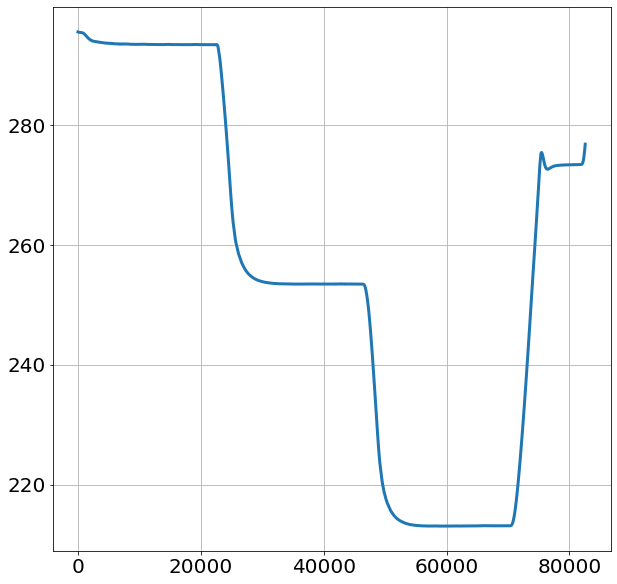

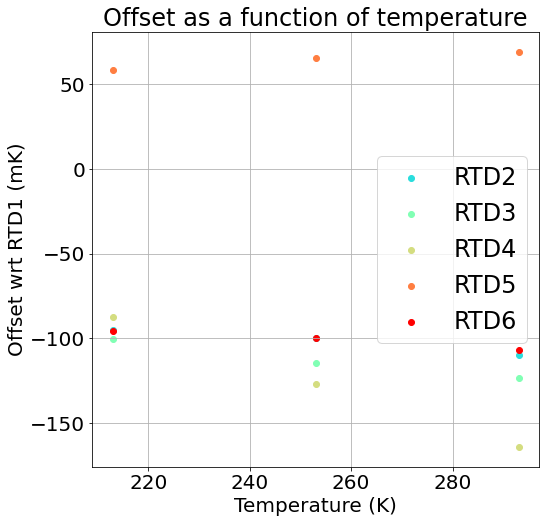

In [21]:
plt.figure(figsize=(10,10))
temp = pd.read_csv(path_to_split+"temperature.txt", header=0)
t0 = temp["Timestamp"][0]
plt.plot(temp["Timestamp"]-t0, temp["T1"])
plateaus = {"293":[10000,20000], "253":[35000,45000], "213":[60000,70000]}
plt.figure(figsize=(8,8))
colors = plt.cm.rainbow(np.linspace(0,1,7))
for key in plateaus.keys():
    tini, tend = plateaus[key][0], plateaus[key][1]
    for i in range(2,7):
        if key == "213":                
            plt.scatter(int(key),
            np.mean((temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T"+str(i)] - temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T1"])*1e3),
            "o",
            color=colors[i],
            label="RTD"+str(i),
            )
        else:
            plt.scatter(int(key),
            np.mean((temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T"+str(i)] - temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T1"])*1e3),
            color=colors[i],
            "o"
            )
        # plt.plot(temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["Timestamp"],
        # (temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T"+str(i)] - temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T1"])*1e3,
        # label="RTD{0:.0f} ; STD={1:.1f} mK".format(i, np.std((temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T"+str(i)] - temp.loc[(temp["Timestamp"]-t0>tini) & (temp["Timestamp"]-t0<tend)]["T1"])*1e3)),
        # color=colors[i])
    # plt.plot(temp["Timestamp"]-temp["Timestamp"][0], temp["T2"], label="RTD2")
plt.title("Offset as a function of temperature")
plt.xlabel("Temperature (K)")
plt.ylabel("Offset wrt RTD1 (mK)")
plt.grid("on")
plt.legend()

An example on how to calculate one of the points of the sensitivity plot, for a single plateau.

The temperature for the RTD1 (connected to channel 1) is much less noisy than that for the RTD2. We will get the temperature value out of the RTD1 for this analysis.

/afs/cern.ch/user/j/jcapotor/FBGana/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


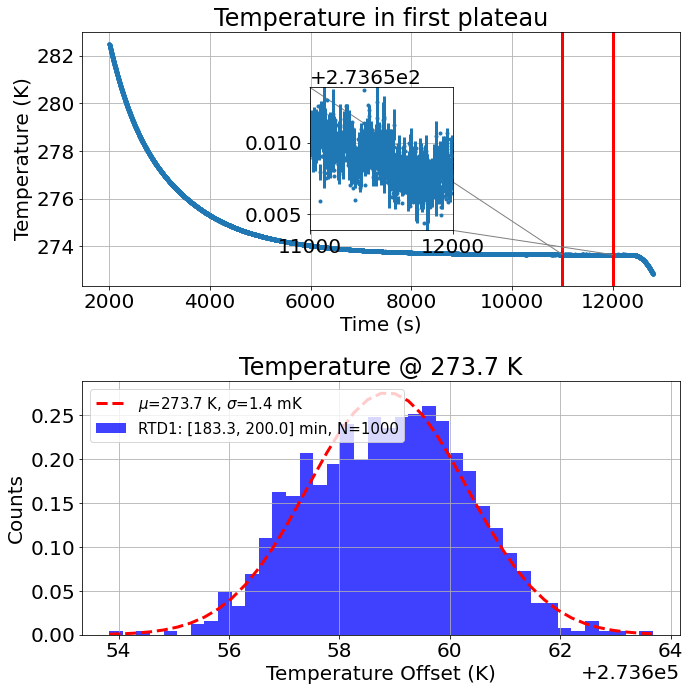

In [5]:
t1 = temp.loc[(temp["Timestamp"] - t0 > 2000) & (temp["Timestamp"] - t0 < 12800)].reset_index(drop=True)
tini, tfin = 11000, 12001
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[10,10])
axes[0].set_title("Temperature in first plateau")
axes[0].plot(t1["Timestamp"] - t0, t1["T1"], ".")
axes[0].axvline((temp["Timestamp"]-t0)[tini], color="red")
axes[0].axvline((temp["Timestamp"]-t0)[tfin], color="red")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Temperature (K)")
t1 = temp.loc[(temp["Timestamp"] - t0 > tini) & (temp["Timestamp"] - t0 < tfin)].reset_index(drop=True)
axins = zoomed_inset_axes(axes[0], 600, loc="center")
axins.errorbar(x=t1["Timestamp"] - t0, y=t1["T1"], yerr=t1["T1_err"], fmt=".")
axins.set_box_aspect(1)
axins.set_xlim(tini, tfin)
axins.set_ylim(np.mean(t1["T1"]) - 0.005, np.mean(t1["T1"]) + 0.005)
mark_inset(axes[0], axins, loc1=2, loc2=4, fc="none", ec="0.5")

(mu, sigma) = norm.fit(t1["T1"]*1e3)
n, bins, patches = axes[1].hist(t1["T1"]*1e3, bins=40, density=True, facecolor='blue', alpha=0.75, label=r"RTD1: [{0:.1f}, {1:.1f}] min, N={2:.0f}".format(tini/60, tfin/60, len(t1["T1"])))
gauss_fit = norm.pdf( bins, mu, sigma)
axes[1].plot(bins, gauss_fit, 'r--', label=r"$\mu$={0:.1f} K, $\sigma$={1:.1f} mK".format(mu*1e-3, sigma))
axes[1].set_title(r"Temperature @ {0:.1f} K".format(np.mean(t1["T1"])))
axes[1].set_ylabel("Counts")
axes[1].set_xlabel("Temperature Offset (K)")
axes[1].grid("on")
axes[1].legend(fontsize=15)
fig.tight_layout()

/afs/cern.ch/user/j/jcapotor/FBGana/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


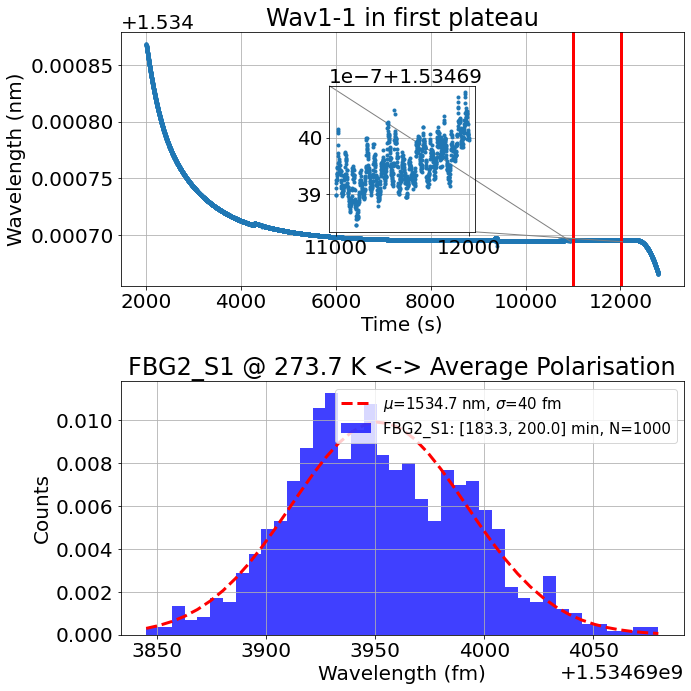

In [37]:
t1 = temp.loc[(temp["Timestamp"] - t0 > 2000) & (temp["Timestamp"] - t0 < 12800)].reset_index(drop=True)
ts_p = np.empty(0, dtype=float)
ts_s = np.empty(0, dtype=float)
wav11_p = np.empty(0, dtype=float)
wav12_p = np.empty(0, dtype=float)
wav11_s = np.empty(0, dtype=float)
wav12_s = np.empty(0, dtype=float)
for i in range(1,24):
    peaks_p = pd.read_csv(path_to_split+"Peaks_processed_P_"+str(i)+".txt")
    peaks_s = pd.read_csv(path_to_split+"Peaks_processed_S_"+str(i)+".txt")
    peaks_p, temp_p = manage_data.match_dataframes(peaks_p, t1)
    peaks_s, temp_s = manage_data.match_dataframes(peaks_s, t1)
    peaks_p = peaks_p.loc[(peaks_p["Wav1-1"] > 1.5e-6)]
    peaks_s = peaks_s.loc[(peaks_s["Wav1-1"] > 1.5e-6)]
    if peaks_p.empty:
        continue
    ts_p = np.concatenate((ts, peaks_p["Timestamp"].values))
    wav11_p = np.concatenate((wav11_p, peaks_p["Wav1-1"].values))
    wav12_p = np.concatenate((wav12_p, peaks_p["Wav1-2"].values))
    if peaks_p.empty:
        continue
    wav11_s = np.concatenate((wav11_s, peaks_s["Wav1-1"].values))
    wav12_s = np.concatenate((wav12_s, peaks_s["Wav1-2"].values))


tini, tfin = 11000, 12001
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[10,10])
axes[0].set_title("Wav1-1 in first plateau")
axes[0].plot(ts - t0, (wav11_p)*1e6, ".")
axes[0].axvline((temp["Timestamp"]-t0)[tini], color="red")
axes[0].axvline((temp["Timestamp"]-t0)[tfin], color="red")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Wavelength (nm)")

t1 = temp.loc[(temp["Timestamp"] - t0 > tini) & (temp["Timestamp"] - t0 < tfin)].reset_index(drop=True)
ts = np.empty(0, dtype=float)
wav11_p = np.empty(0, dtype=float)
wav12_p = np.empty(0, dtype=float)
wav11_s = np.empty(0, dtype=float)
wav12_s = np.empty(0, dtype=float)
for i in range(1,24):
    peaks_p = pd.read_csv(path_to_split+"Peaks_processed_P_"+str(i)+".txt")
    peaks_s = pd.read_csv(path_to_split+"Peaks_processed_S_"+str(i)+".txt")
    peaks_p, temp_p = manage_data.match_dataframes(peaks_p, t1)
    peaks_s, temp_s = manage_data.match_dataframes(peaks_s, t1)
    peaks_p = peaks_p.loc[(peaks_p["Wav1-1"] > 1.5e-6)]
    peaks_s = peaks_s.loc[(peaks_s["Wav1-1"] > 1.5e-6)]
    if peaks_p.empty:
        continue
    ts = np.concatenate((ts, peaks_p["Timestamp"].values))
    wav11_p = np.concatenate((wav11_p, peaks_p["Wav1-1"].values))
    wav12_p = np.concatenate((wav12_p, peaks_p["Wav1-2"].values))
    if peaks_p.empty:
        continue
    wav11_s = np.concatenate((wav11_s, peaks_s["Wav1-1"].values))
    wav12_s = np.concatenate((wav12_s, peaks_s["Wav1-2"].values))
axins = zoomed_inset_axes(axes[0],500, loc="center")
axins.errorbar(x=t1["Timestamp"] - t0, y=(wav11_s)*1e6, yerr=0, fmt=".")
axins.set_box_aspect(1)
mark_inset(axes[0], axins, loc1=2, loc2=4, fc="none", ec="0.5")

(mu, sigma) = norm.fit((wav11_s)*1e15)
n, bins, patches = axes[1].hist((wav11_s)*1e15, bins=40, density=True, facecolor='blue', alpha=0.75, label=r"FBG2_S1: [{0:.1f}, {1:.1f}] min, N={2:.0f}".format(tini/60, tfin/60, len(t1["T1"])))
gauss_fit = norm.pdf( bins, mu, sigma)
axes[1].plot(bins, gauss_fit, 'r--', label=r"$\mu$={0:.1f} nm, $\sigma$={1:.0f} fm".format(mu*1e-6, sigma))
axes[1].set_title(r"FBG2_S1 @ {0:.1f} K <-> Average Polarisation".format(np.mean(t1["T1"])))
axes[1].set_ylabel("Counts")
axes[1].set_xlabel("Wavelength (fm)")
axes[1].grid("on")
axes[1].legend(fontsize=15)
fig.tight_layout()